# Pitfalls of retrieval - When simple vector search fails!
## Introduction
In this lesson we'll show that semantic similarities is not always that perfect

## Installation

In [1]:
%pip install -q -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


## Connecting to our existing Vector database

In [2]:
import chromadb
from helper_utils import load_chroma, word_wrap
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction
from chromadb.config import DEFAULT_TENANT, DEFAULT_DATABASE, Settings

chroma_client = chromadb.PersistentClient(
    path="data/chroma_db/",
    settings=Settings(),
    tenant=DEFAULT_TENANT,
    database=DEFAULT_DATABASE,
)
# Load the existing collection by its name
collection_name = 'microsoft_annual_report_2022'
chroma_collection = chroma_client.get_or_create_collection(name=collection_name)

# Count the number of items in the collection
count = chroma_collection.count()
print(f"Number of items in the collection '{collection_name}': {count}")

Number of items in the collection 'microsoft_annual_report_2022': 349


## Setting up the embedding model

In [3]:
# Access the underlying SentenceTransformer model (Defults)
embedding_function = SentenceTransformerEmbeddingFunction()
model = embedding_function.models
print(model)

/home/vscode/my-envs/03-rag-graph-databases/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


{'all-MiniLM-L6-v2': SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)}


/home/vscode/my-envs/03-rag-graph-databases/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## Helper function to show the results from a vector search

In [4]:
def print_results_and_documents(results, retrieved_documents, word_wrap):
    """
    Prints keys and values from the results dictionary and documents with word wrapping.

    Args:
        results (dict): A dictionary where keys are strings and values are either strings or lists.
        retrieved_documents (list): A list of documents to be printed.
        word_wrap (function): A function to apply word wrapping to the documents.

    Returns:
        None
    """
    # Iterate through the dictionary and print each key with its associated value
    for key, value in results.items():
        print(f"{key}:")

        # Check if the value is a list and print its elements
        if isinstance(value, list):
            for i, item in enumerate(value):
                print(f"  Item {i+1}: {item}")
        else:
            # Directly print the value if it's not a list
            print(f"  {value}")

        print()  # Add a newline for better readability

    # Iterate through the list of documents and print each one with word wrapping
    for document in retrieved_documents:
        print(word_wrap(document))
        print('\n')


## Visualize the embeddings

In [5]:
import umap
import numpy as np
from tqdm import tqdm

embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)

/home/vscode/my-envs/03-rag-graph-databases/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [6]:
def project_embeddings(embeddings, umap_transform):
    umap_embeddings = np.empty((len(embeddings),2))
    for i, embedding in enumerate(tqdm(embeddings)): 
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings   

In [7]:
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

100%|██████████| 349/349 [02:49<00:00,  2.06it/s]


(-3.4154350757598877, 8.407795190811157, 4.709564852714538, 10.310185265541076)

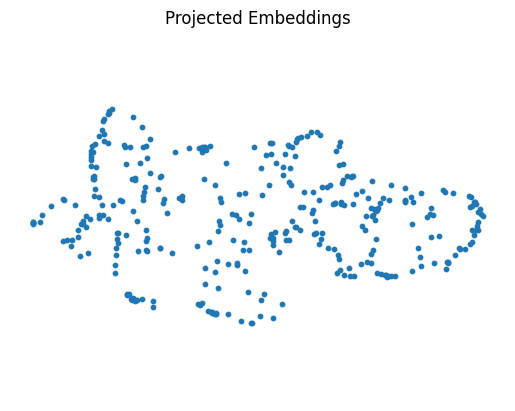

In [8]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10)
plt.gca().set_aspect('equal', 'datalim')
plt.title('Projected Embeddings')
plt.axis('off')

## Visualizing the result of a query

In [9]:
query = "What is the total revenue?"

results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings', "distances"])
retrieved_documents = results['documents'][0]

print_results_and_documents(results, retrieved_documents, word_wrap)

ids:
  Item 1: ['321', '293', '319', '168', '320']

distances:
  Item 1: [0.3610587830431461, 0.3670606017112732, 0.40163043127695297, 0.40731507539749146, 0.4107680523557089]

metadatas:
  None

embeddings:
  Item 1: [[0.006851615849882364, -0.07879453152418137, -0.013295024633407593, -0.018663959577679634, -0.01320614479482174, 0.05207332223653793, 0.024349980056285858, 0.029772840440273285, 0.0398593433201313, 0.08490502089262009, -0.0272703617811203, 0.04178402200341225, 0.050083816051483154, -0.021252332255244255, -0.029229924082756042, 0.003365496639162302, 0.025213973596692085, -0.11350663006305695, 0.02950187586247921, -0.01701783761382103, -0.014468980953097343, 0.03350761905312538, -0.055656228214502335, -0.038956690579652786, 0.02398926019668579, 0.006582111585885286, -0.054270368069410324, -0.02146941050887108, -0.015810992568731308, -0.06164819747209549, -0.07168304920196533, 0.031110158190131187, -0.007594883441925049, 0.08013573288917542, 0.0024636457674205303, -0.079400

In [10]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


(-3.4154350757598877, 8.407795190811157, 4.709564852714538, 10.310185265541076)

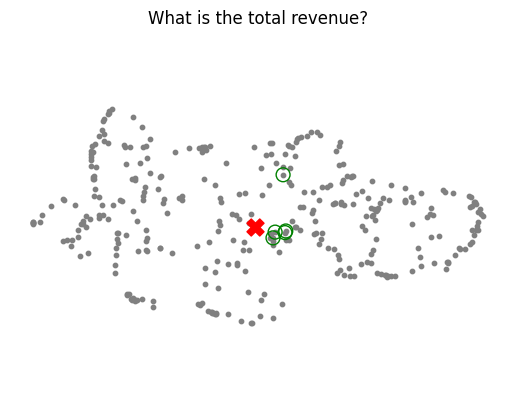

In [11]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')

Note: The one chucnk seems far away however, the 384 dimensions have been collapsed into 2D. 

## Another query

In [12]:
query = "What is the strategy around artificial intelligence (AI) ?"

results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings', "distances"])
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings', "distances"])
retrieved_documents = results['documents'][0]

print_results_and_documents(results, retrieved_documents, word_wrap)

ids:
  Item 1: ['40', '18', '14', '19', '106']

distances:
  Item 1: [0.5352953672409058, 0.6176723837852478, 0.6280008554458618, 0.641973078250885, 0.6422544717788696]

metadatas:
  None

embeddings:
  Item 1: [[-0.0007179570966400206, -0.05684620141983032, -0.008574575185775757, 0.007455119397491217, 0.025688447058200836, -0.044237907975912094, 0.029643306508660316, -0.0050614397041499615, -0.0207978542894125, 0.006971775554120541, -0.07169297337532043, -0.026293504983186722, 0.07952020317316055, -0.01889166422188282, 0.014490759000182152, 0.017577964812517166, 0.03789203613996506, -0.08212697505950928, -0.13293389976024628, -0.07298142462968826, -0.07722480595111847, -0.001983282156288624, -0.05991487577557564, -0.006256323307752609, -0.03309575468301773, 0.03584097698330879, -0.03484262526035309, -0.020084146410226822, -0.058762356638908386, -0.06741998344659805, 0.06361812353134155, 0.016253557056188583, 0.006386954337358475, 0.06352409720420837, 0.007509962189942598, 0.0579507648

Note: This sentence is what probably gave it the closest distance.

 "we are building a distributed computing fabric – across cloud and the edge – to help every organization build, run, and manage mission - critical workloads anywhere. in the next phase of innovation, artificial intelligence ( “ ai ” ) capabilities are rapidly advancing, fueled by data and knowledge of the world."

In [13]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)


100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


(-3.4154350757598877, 8.407795190811157, 4.709564852714538, 10.310185265541076)

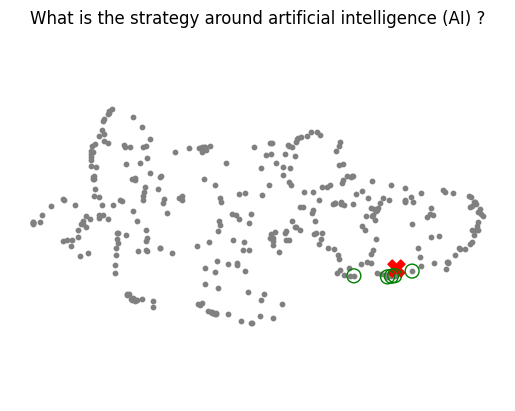

In [14]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')

In [15]:
query = "What has been the investment in research and development?"

results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings', "distances"])
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings', "distances"])
retrieved_documents = results['documents'][0]

#print_results_and_documents(results, retrieved_documents, word_wrap)

Note: IDs 110 3 and 63 are considered distractors. If they are passed to an LLM it's harder to debug. 

In [16]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)


100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


(-3.4154350757598877, 8.407795190811157, 4.709564852714538, 10.310185265541076)

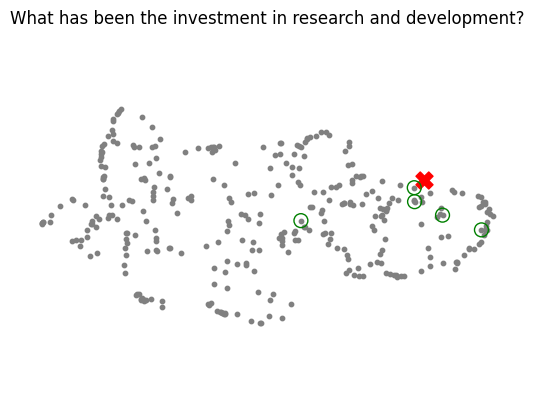

In [17]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')

In [18]:
query = "What has Michael Jordan done for us lately?"

results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings', "distances"])
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings', "distances"])
retrieved_documents = results['documents'][0]

#print_results_and_documents(results, retrieved_documents, word_wrap)

In [19]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


(-3.4154350757598877, 8.407795190811157, 4.709564852714538, 10.310185265541076)

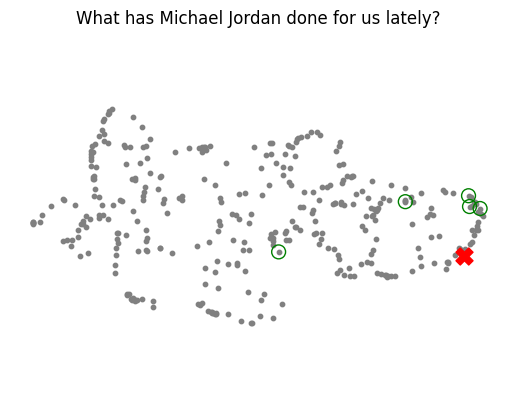

In [20]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')